In [20]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.filters import sobel_h, sobel_v, scharr, gabor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score

# Redimensionarea imaginii

In [21]:
#functie care redimensioneaza imaginea
def resize_image(image):
    new_width = 25
    new_height = 25
    new_dimensions = (new_width, new_height)

    resized_image = cv2.resize(image, new_dimensions)
    return resized_image

# Inserare imagine de test
Pentru a arata rezultatul operatorilor am ales o imagine de test.

In [22]:
image_for_test = cv2.imread('boabe_de_fasole.jpg',0)
#image_for_test = resize_image(image_for_test)

# Implementare functie de convolutie 

In [23]:
def convolution(image, kernel):
        height, width = image.shape
        #k_height, k_width = kernel.shape
        result = np.zeros((height, width), dtype=np.float32) #creeaza o matrice rezultat initiata cu 0
                                                           # cu tipul de date "unit8" pt a reprezenta intensitatile de pixel

#parcurgem pixelii si aplicam convolutia
        for i in range(1, height - 1): #parcurgere pixeli pe axa verticala
            for j in range(1, width - 1): #parcurgere pixeli pe axa orizontala
                roi = image[i-1:i+2, j-1:j+2] #se extrage o regiune de interes(ROI) din imaginea originala in jurul pixelului curent (ROI se suprapune peste kernel pt a efectua operatia de convolutie)
                result[i, j] = np.sum(roi * kernel) #suma este atribuita pixelului corespunzator din img rezultata

        return result

### Functie pentru afisarea rezultatelor

In [24]:
def display_result(horizontal_edges, vertical_edges, x, y):
#magnitude
    edge_magnitude = np.sqrt(np.square(horizontal_edges) + np.square(vertical_edges))
    edge_magnitude_cv2 =  np.sqrt(np.square(x) + np.square(y))

#afisare rezultatele operatoului implementat printr-o functie proprie
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 4, 1), plt.imshow(image_for_test, cmap='gray', vmin=0, vmax=255)
    plt.title('Imaginea originala'), plt.axis('off')

    plt.subplot(2, 4, 2), plt.imshow(horizontal_edges, cmap='gray', vmin=0, vmax=255)
    plt.title('Margini orizontale(impl proprie)'), plt.axis('off')

    plt.subplot(2, 4, 3), plt.imshow(vertical_edges, cmap='gray', vmin=0, vmax=255)
    plt.title('Margini verticale(impl proprie)'), plt.axis('off')

    plt.subplot(2, 4, 4), plt.imshow(edge_magnitude, cmap='gray', vmin=0, vmax=255)
    plt.title('Magnitudinea(impl proprie)'), plt.axis('off')

#afisare rezultatele operatoului implementat prin cv2
    plt.subplot(2, 4, 6), plt.imshow(x, cmap='gray', vmin=0, vmax=255), plt.axis('off')
    plt.title('Margini verticale(cv2)')
    plt.subplot(2, 4, 7), plt.imshow(y, cmap='gray', vmin=0, vmax=255), plt.axis('off')
    plt.title('Margini verticale(cv2)')
    plt.subplot(2, 4, 8), plt.imshow(edge_magnitude_cv2, cmap='gray', vmin=0, vmax=255), plt.axis('off')
    plt.title('Magnitudinea(cv2)')


#afisare histograme
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.hist(image_for_test.ravel(), bins=256, range=(0, 255))
    plt.title('Histograma imaginii originale')
    plt.xlabel('Intensitatea pixelilor')
    plt.ylabel('Frecventa')

    plt.subplot(1, 3, 2)
    plt.hist(x.ravel(), bins=256, range=(0, 255))
    plt.title('Histograma marginilor orizontale')
    plt.xlabel('Intensitatea pixelilor')
    plt.ylabel('Frecventa')

    plt.subplot(1, 3, 3)
    plt.hist(y.ravel(), bins=256, range=(0, 255))
    plt.title('Histograma marginilor verticale')
    plt.xlabel('Intensitatea pixelilor')
    plt.ylabel('Frecventa')

    plt.tight_layout()
    plt.show()

# Implementare operator Prewitt fara functie predefinita

In [25]:
def prewitt_edge_detection(image):
    #definire masti
    kernel_horizontal = np.array([[1, 1, 1],
                                  [0, 0, 0],
                                  [-1, -1, -1]])

    kernel_vertical = np.array([[-1, 0, 1],
                                [-1, 0, 1],
                                [-1, 0, 1]])

    #aplicare convolutie
    prewitt_horizontal_manual = convolution(image, kernel_horizontal)
    prewitt_vertical_manual = convolution(image, kernel_vertical)

    return prewitt_horizontal_manual, prewitt_vertical_manual

# Rezultate operator Prewitt

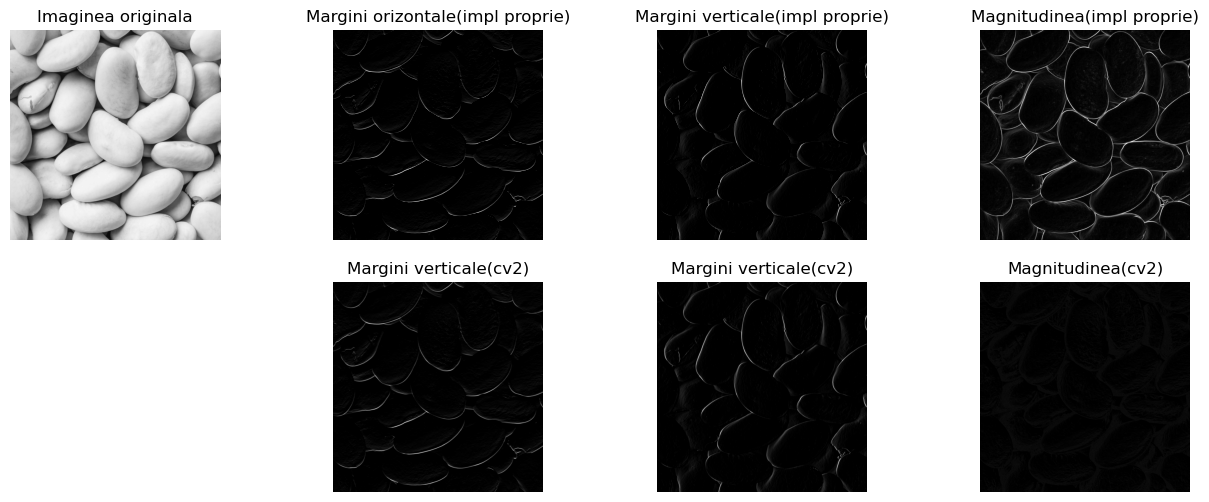

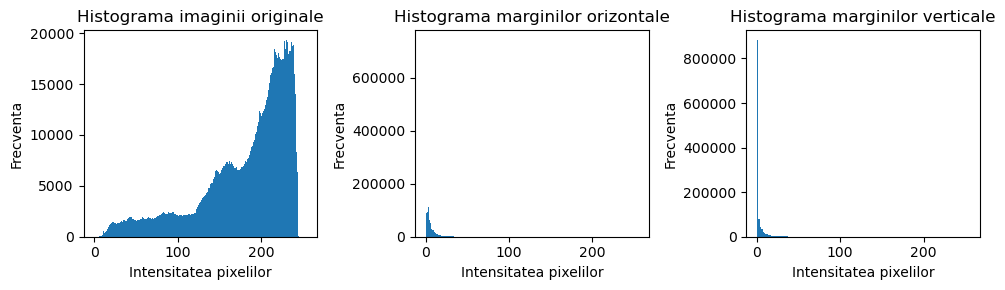

In [26]:
#definire masti pentru operatorul Prewitt:
kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

#aplicare estompare Gaussiana pentru reducerea zgomotului
blurred_image = cv2.GaussianBlur(image_for_test, (3, 3), 0)
prewittx = cv2.filter2D(blurred_image, -1, kernelx)
prewitty = cv2.filter2D(blurred_image, -1, kernely)

horizontal_edges_prewitt, vertical_edges_prewitt = prewitt_edge_detection(image_for_test)

display_result(horizontal_edges_prewitt, vertical_edges_prewitt, prewittx, prewitty)


# Implementare operator Sobel fara functie predefinita

In [27]:
def sobel_edge_detection(image):
    #mastile operatorului Sobel
    sobel_horizontal = np.array([[-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]])

    sobel_vertical = np.array([[-1, 0, 1],
                               [-2, 0, 2],
                               [-1, 0, 1]])

    #aplicarea convolutiei
    gradient_x = convolution(image.astype(np.float32), sobel_horizontal);
    gradient_y = convolution(image.astype(np.float32), sobel_vertical);

    return gradient_x, gradient_y

# Rezultate operator Sobel

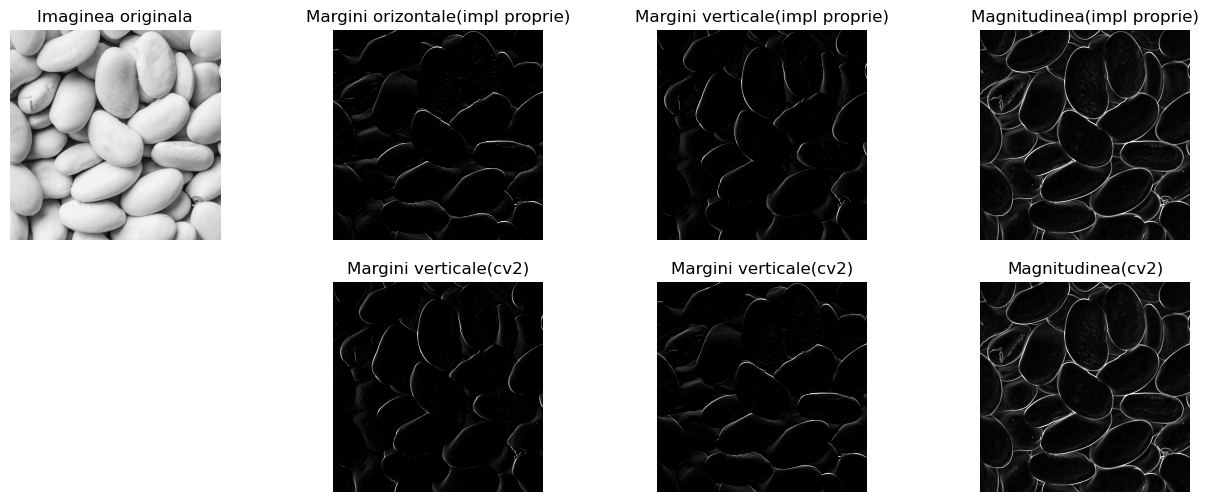

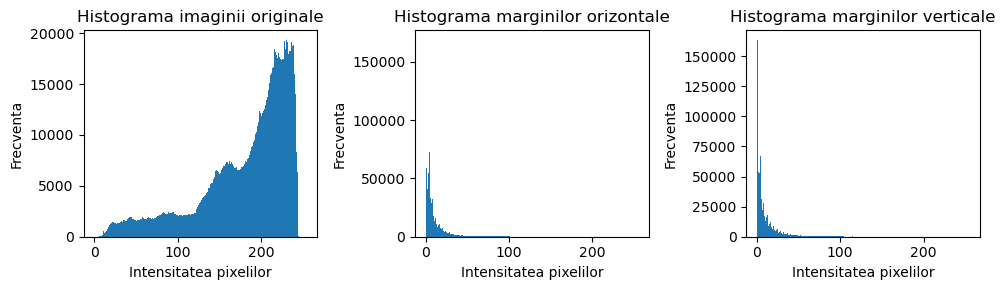

In [28]:
horizontal_edges_sobel, vertical_edges_sobel = sobel_edge_detection(image_for_test)
sobel_x = cv2.Sobel(image_for_test, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image_for_test, cv2.CV_64F, 0, 1, ksize=3)

display_result(horizontal_edges_sobel, vertical_edges_sobel, sobel_x, sobel_y)

# Implementarea operatorului Scharr

In [29]:
def scharr_edge_detection(image):
    # Operator Scharr pentru detectarea muchiilor orizontale
    scharr_horizontal = np.array([[3, 0, -3],
                                  [10, 0, -10],
                                  [3, 0, -3]])

    # Operator Scharr pentru detectarea muchiilor verticale
    scharr_vertical = np.array([[3, 10, 3],
                                [0, 0, 0],
                                [-3, -10, -3]])


    gradient_x = convolution(image.astype(np.float32), scharr_horizontal)
    gradient_y = convolution(image.astype(np.float32), scharr_vertical)

    return gradient_x, gradient_y

# Rezultate operator Scharr 

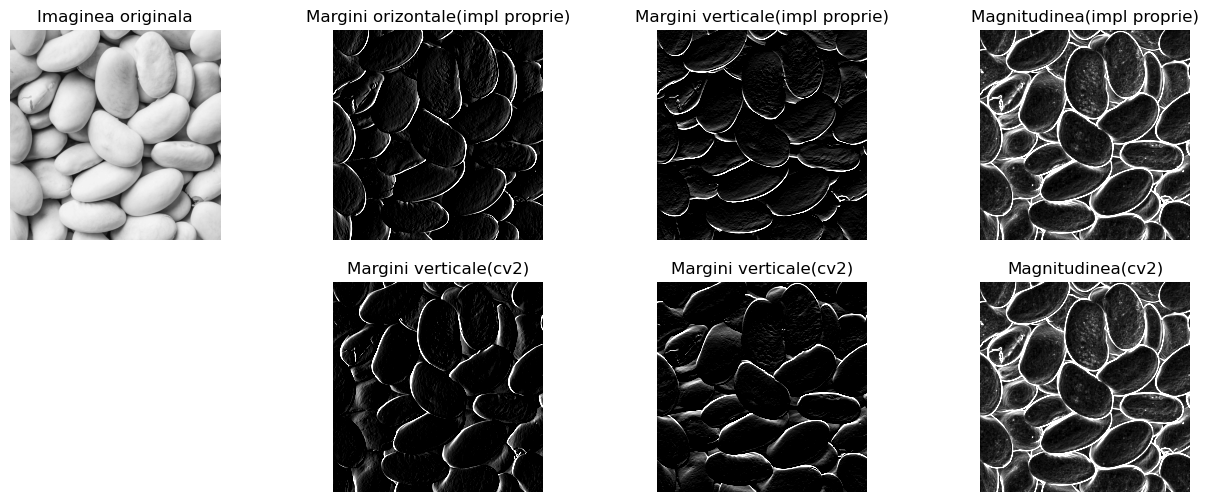

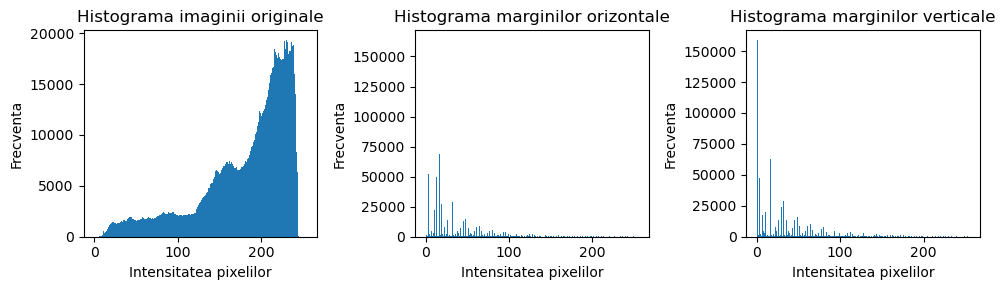

In [30]:
horizontal_edges_scharr, vertical_edges_scharr = scharr_edge_detection(image_for_test)
scharr_x = cv2.Scharr(image_for_test, cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(image_for_test, cv2.CV_64F, 0, 1)

display_result(horizontal_edges_scharr, vertical_edges_scharr, scharr_x, scharr_y)

# Implementare filtru Gabor fara functie predefinita 

In [31]:
def gabor_filter_implementation(image):
    def gabor_kernel(size, sigma, theta, lambd, gamma):
        x, y = np.meshgrid(np.arange(-size//2 + 1, size//2 + 1),
                           np.arange(-size//2 + 1, size//2 + 1))
        x_theta = x * np.cos(theta) + y * np.sin(theta)
        y_theta = -x * np.sin(theta) + y * np.cos(theta)
        gabor = np.exp(-(x_theta**2 + (gamma**2)*y_theta**2) / (2 * sigma**2)) * np.cos(2 * np.pi * x_theta / lambd)
        return gabor

    def convolution(image, kernel):
        height, width = image.shape
        k_height, k_width = kernel.shape
        pad_height = k_height // 2
        pad_width = k_width // 2
        kernel = np.flipud(np.fliplr(kernel))
        image_padded = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
        result = np.zeros((height, width), dtype=np.uint8)
        for i in range(height):
            for j in range(width):
                roi = image_padded[i:i+k_height, j:j+k_width]
                result[i, j] = np.sum(roi * kernel)
        np.copyto(image, result)
        return image
    
    size = 15
    sigma = 2
    theta = 0
    lambd = 3.5
    gamma = 0.3

    gabor_kernel_example = gabor_kernel(size, sigma, theta, lambd, gamma)

    # Aplicare filtru Gabor
    gabor_result = convolution(image, gabor_kernel_example)
    
    # Aplică reducerea de zgomot pe rezultatul convoluției
    gabor_result_denoised = cv2.fastNlMeansDenoising(gabor_result, None, 10, 0)

    return gabor_result_denoised


# Rezultate filtru Gabor

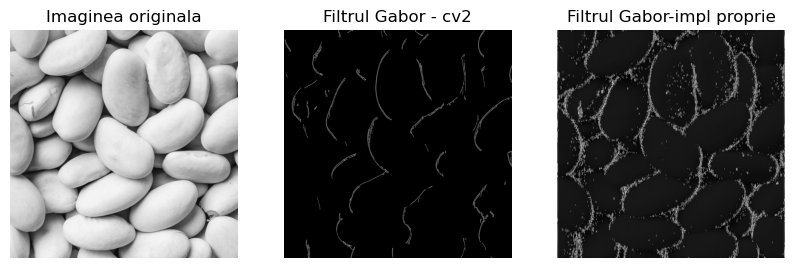

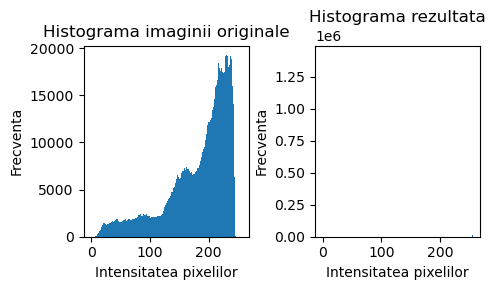

In [32]:
gabor_response_from_function = gabor_filter_implementation(image_for_test);

image_for_test = cv2.imread('boabe_de_fasole.jpg',0)

size = 15
sigma = 1
theta = 0
lambd = 3.5
gamma = 0.3   
 
denoised_image = cv2.medianBlur(image_for_test, 5)
kernel = cv2.getGaborKernel((size, size), sigma, theta, lambd, gamma)
filtered_image = cv2.filter2D(denoised_image, cv2.CV_8UC3, kernel)
edges = cv2.Canny(filtered_image, 50, 150)
    
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1), plt.imshow(image_for_test, cmap='gray', vmin=0, vmax=255)
plt.title('Imaginea originala'), plt.axis('off')
plt.subplot(1, 3, 2), plt.imshow(edges, cmap='gray', vmin=0, vmax=255)
plt.title('Filtrul Gabor - cv2'), plt.axis('off')
plt.subplot(1, 3, 3), plt.imshow(gabor_response_from_function, cmap='gray', vmin=0, vmax=255)
plt.title('Filtrul Gabor-impl proprie'), plt.axis('off')

plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.hist(image_for_test.ravel(), bins=256, range=(0, 255))
plt.title('Histograma imaginii originale')
plt.xlabel('Intensitatea pixelilor')
plt.ylabel('Frecventa')
plt.subplot(1, 2, 2)
plt.hist(edges.ravel(), bins=256, range=(0, 255))
plt.title('Histograma rezultata')
plt.xlabel('Intensitatea pixelilor')
plt.ylabel('Frecventa')

plt.tight_layout()
plt.show()

# Extragere trasaturi
Prewitt, Sobel , Scharr, filtru Gabor. Includerea acestora in vectorul de trasaturi

In [33]:
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #gray = resize_image(gray) #redimensionare imagine
    
    #-----Prewitt---------------------
    # extragere Prewitt cu ajutorul functiei
    kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    prewittx = cv2.filter2D(image, -1, kernelx)
    kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    prewitty = cv2.filter2D(image, -1, kernely)
    
    #Prewitt-implementare proprie
    horizontal_edges_prewitt, vertical_edges_prewitt = prewitt_edge_detection(gray);
    
    #-----Sobel---------------------
    #extragere Sobel cu ajutorul functiei din CV2
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    #Sobel-implementare proprie
    gradient_x_sobel, gradient_y_sobel = sobel_edge_detection(gray);
    
    #-----Scharr---------------------
    scharr_x = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharr_y = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    
    #Scharr-implementare proprie
    gradient_x_scharr, gradient_y_scharr = scharr_edge_detection(gray);
    
    
    #Combinam rezultatele intr-un vector de trasaturi
    feature_vector = np.hstack([prewittx.flatten(), prewitty.flatten(),
                                horizontal_edges_prewitt.flatten(), vertical_edges_prewitt.flatten(), 
                                sobel_x.flatten(), sobel_y.flatten(),
                                gradient_x_sobel.flatten(), gradient_y_sobel.flatten(),
                                scharr_x.flatten(), scharr_y.flatten(), 
                                gradient_x_scharr.flatten(), gradient_y_scharr.flatten() ])

    # implementare filtru Gabor
    size = 15      # Kernel size (odd for symmetry)
    sigma = 1    # Standard deviation of the Gabor kernel
    theta = 0      # Orientation of the Gabor kernel in radians
    lambd = 3.5   # Wavelength of the Gabor sinusoids
    gamma = 0.3    # Aspect ratio
 
    kernel = cv2.getGaborKernel((size, size), sigma, theta, lambd, gamma)
    filtered_image = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
    edges = cv2.Canny(filtered_image, 50, 150)

    gabor_response_from_function = gabor_filter_implementation(gray);
    
    feature_vector = np.hstack([feature_vector, edges.flatten(), gabor_response_from_function.flatten()])

     # Impunerea unei lungimi fixe al vectorului de trasaturi
    fixed_length = 10000 
    if len(feature_vector) < fixed_length:
        feature_vector = np.pad(feature_vector, (0, fixed_length - len(feature_vector)), 'constant')
    elif len(feature_vector) > fixed_length:
        feature_vector = feature_vector[:fixed_length]

    
    return feature_vector

# Incarcare date de test

In [34]:
def load_dataset_pixel_vectors(folder_path):
    class_vectors = {
        "boabe_de_fasole": [],
        "nisip": [],
        "pietris": [],
        "other": []
    }

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".png") or img_path.endswith(".jpeg"):
            image = cv2.imread(img_path)
            image = resize_image(image)
            if image is not None:
                for i in range(image.shape[0]):
                    for j in range(image.shape[1]):
                        pixel = image[i, j]  # Extract the pixel
                        extracted_feature = extract_texture_features(image)

                        if extracted_feature is not None:
                            if "fasole" in filename:
                                class_vectors["boabe_de_fasole"].append(extracted_feature)
                            elif "nisip" in filename:
                                class_vectors["nisip"].append(extracted_feature)
                            elif "pietris" in filename:
                                class_vectors["pietris"].append(extracted_feature)
                            else:
                                class_vectors["other"].append(extracted_feature)
                        else:
                            print(f"Error extracting feature for pixel: ({i}, {j}) in the image {filename}")
            else:
                print(f"Error loading the image: {img_path}")

    # Convert lists to numpy arrays
    for key in class_vectors:
        class_vectors[key] = np.array(class_vectors[key])

    return class_vectors


In [35]:
dataset_pixel_labels_path = 'imagini_de_antrenare'

class_vectors = load_dataset_pixel_vectors(dataset_pixel_labels_path)

# Combining the class vectors and creating corresponding labels
X = np.vstack([class_vectors[label] for label in class_vectors if len(class_vectors[label]) > 0])
y = np.concatenate([[label] * len(class_vectors[label]) for label in class_vectors if len(class_vectors[label]) > 0])

#impartim lista in date de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#pentru clasificare utilizam SVM
svm_classifier = SVC(kernel='linear')

#antrenare SVM
svm_classifier.fit(X_train, y_train)

predictions = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


In [36]:
# After training the SVM classifier
support_vectors = svm_classifier.support_vectors_
dual_coefs = svm_classifier.dual_coef_
intercept = svm_classifier.intercept_

class_vectors = {}
classes = svm_classifier.classes_

for idx, class_label in enumerate(classes):
    class_idx = np.where(y_train == class_label)[0]  # Get indices from y_train
    if len(class_idx) > 0:
        class_idx = class_idx[0]  # Take the first index for the class
        class_dual_coef = dual_coefs[:, class_idx].ravel()  # Extract dual coefficients for this class

        mask = (class_dual_coef != 0)
        non_zero_indices = np.nonzero(mask)[0]  # Get indices where mask is True

        class_support_vectors = support_vectors[non_zero_indices]
        class_dual_coef = class_dual_coef[non_zero_indices]
        class_dual_coef /= np.linalg.norm(class_dual_coef)  # Normalize dual coefficients

        class_representation = np.zeros_like(class_support_vectors[0])

        for coef, vector in zip(class_dual_coef, class_support_vectors):
            class_representation += coef * vector

        class_representation -= intercept[idx] / np.linalg.norm(class_representation)

        class_vectors[class_label] = class_representation


In [37]:
def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        pixel_features = extract_texture_features(image)  
        return pixel_features
    else:
        print("Eroare la incarcarea imaginii")
        return None

# Testare pe o alta imagine

In [38]:

new_image_path = 'pietris.jpg'  
new_image_features = extract_features_from_image(new_image_path)  # Extract features from the new image

similarities = {}
for class_label, class_representation in class_vectors.items():
    similarity = cosine_similarity(new_image_features.reshape(1, -1), class_representation.reshape(1, -1))
    similarities[class_label] = similarity[0][0]
    
predicted_class = max(similarities, key=similarities.get)
 
if predicted_class == "boabe_de_fasole":
    print("In imagine sunt boabe de fasole.")
elif predicted_class == "pietris":
    print("In imagine este pietris.")
elif predicted_class == "nisip":
    print("In imagine este nisip")
else:
    print("Imagine nu corespunde caracteristicilor antrenate")
   

In imagine sunt boabe de fasole.


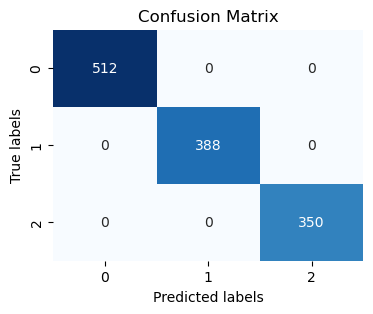

                 precision    recall  f1-score   support

boabe_de_fasole       1.00      1.00      1.00       512
          nisip       1.00      1.00      1.00       388
        pietris       1.00      1.00      1.00       350

       accuracy                           1.00      1250
      macro avg       1.00      1.00      1.00      1250
   weighted avg       1.00      1.00      1.00      1250



In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming y_test contains the true labels and predictions contains the predicted labels
# classification_report provides a detailed report, including precision, recall, F1-score, and support

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Displaying confusion matrix using seaborn heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(y_test, predictions, zero_division=1))

#precision =  abilitatea modelului de a identifica toate instantele relevante din setul de date
           # = masura a falselor clasificari
#recall = masura a non-detectiilor = abilitatea clasificatorului de a identifica doar cazurile relevante din setul de date
#f1-score = masura care combina precision si recall intr-un mod unitar
